Here we use the components extracted in the previous step and the timestamped data from the behavior

In [30]:
# Load the libraries
import caiman as cm
from caiman.source_extraction import cnmf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
from matplotlib.patches import Polygon
from matplotlib.path import Path
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import json
from scipy.sparse import csc_matrix

from IPython import get_ipython
import IPython


from scipy.ndimage import binary_erosion

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

In [2]:
# Load the data
path = 'D:/CaIm/os80/lawa2/'

# Video
os80 = 'D:/CaIm/os80/memmap__d1_512_d2_512_d3_1_order_C_frames_12000.mmap'  # Replace with your .mmap file path
os80_lawa2 = path + 'memmap_0001_d1_512_d2_512_d3_1_order_C_frames_5889.mmap'
mmap_file_path = os80_lawa2
Yr, dims, T = cm.load_memmap(mmap_file_path)
#Reshape the data back into a movie:
images = np.reshape(Yr.T, [T] + list(dims), order='F')

# Components data from JSON files
a_data = path + 'A_data.json'
c_data = path + 'C_data.json'

with open(a_data, 'r') as json_file:
    A_list = json.load(json_file)
with open(c_data, 'r') as json_file:
    C_list = json.load(json_file)

# Convert lists back to numpy array and then to sparse matrix if needed
A_array = np.array(A_list)
A_sparse = csc_matrix(A_array)
C_array = np.array(C_list)

# show a frame
#plt.imshow(images[0], cmap='gray')
#plt.show()

select a poligon where neurons could be

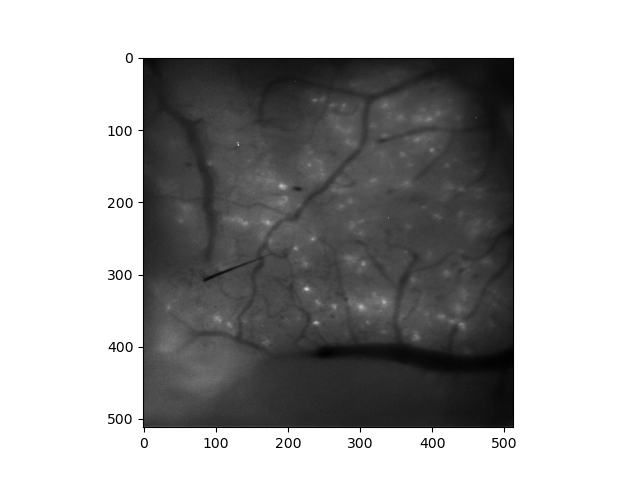

In [3]:
%matplotlib widget
#%matplotlib ipympl
# Make an image with max values of intensity
max_image = np.max(images, axis=0)


fig, ax = plt.subplots()
ax.imshow(max_image, cmap='gray')
polygon_points = []

def on_click(event):
    if event.inaxes is not None:
        polygon_points.append((event.xdata, event.ydata))
        ax.plot(event.xdata, event.ydata, 'ro')  # Mark the vertices
        
        if len(polygon_points) == 7:  # When 7 points are chosen
            poly = Polygon(polygon_points, closed=True, edgecolor='r', fill=False)
            ax.add_patch(poly)
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event

            plt.draw()

cid = fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()


In [4]:
# Original dimentions
d1 = 512
d2 = 512

def calculate_centroid(A_array, component_num, d1, d2):
    """Calculate the centroid of a component."""
    component = A_array[:, component_num].reshape(d1, d2)
    ys, xs = np.nonzero(component)
    if len(xs) == 0 or len(ys) == 0:
        return None  # or some default value like (0, 0)
    return np.mean(xs), np.mean(ys)

# Assuming A_array shape is (height, width, num_components)
#spatial_component = A_array[:, component_num].reshape(d1, d2)
centroids = [calculate_centroid(A_array, i, d1, d2) for i in np.arange(A_array.shape[1])]

# Filter out None values if there are any
centroids = [centroid for centroid in centroids if centroid is not None]


def is_inside_polygon(points, polygon):
    path = Path(polygon)
    return np.array([path.contains_point(point) for point in points])

is_inside = is_inside_polygon(centroids, polygon_points)

# Filter arrays
A_array_filtered = A_array[:, is_inside]
C_array_filtered = C_array[is_inside, :]


plot a neuron location on the overlay of the max image and a trace of this neuron

9 109 182 282


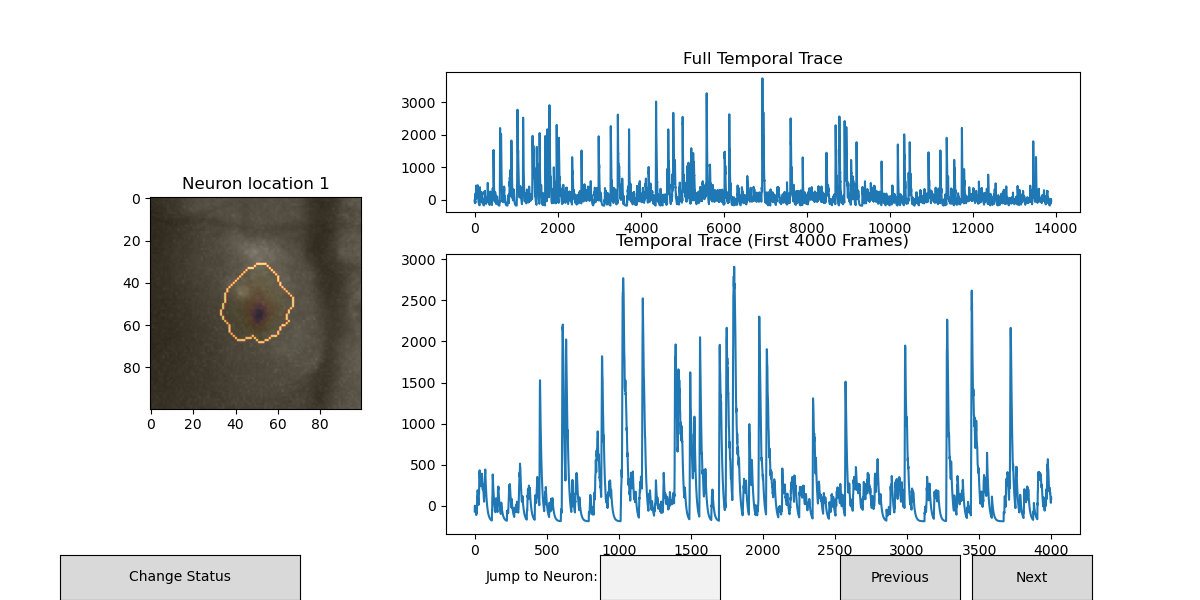

In [37]:
%matplotlib widget

# Original dimentions
d1 = 512
d2 = 512

# Initial component number
component_num = 0

A_array = A_array_filtered
C_array = C_array_filtered
status_array = np.zeros((A_array_filtered.shape[1]), dtype=int)

# Plot a certain neuron
def update_plot(component_num):
    spatial_component = A_array[:, component_num].reshape(d1, d2)
    temporal_component = C_array[component_num, :]
    centroid_x, centroid_y = calculate_centroid(A_array, component_num, d1, d2)

    # Define crop boundaries
    crop_size = 50
    x_min, x_max = round(max(0, centroid_x - crop_size)), round(min(d2, centroid_x + crop_size))
    y_min, y_max = round(max(0, centroid_y - crop_size)), round(min(d1, centroid_y + crop_size))
    print(x_min, x_max, y_min, y_max)
    crop_bounds = (y_min, y_max, x_min, x_max)
    # Crop the max_image and spatial_component
    cropped_image = max_image[y_min:y_max, x_min:x_max]
    cropped_spatial_component = spatial_component[y_min:y_max, x_min:x_max]
    
    axs[0].clear()
    axs[0].imshow(cropped_image, cmap='grey')
    axs[0].imshow(cropped_spatial_component, cmap='inferno_r', alpha=0.3)
    plot_boundaries(axs[0], spatial_component, crop_bounds)
    axs[0].set_title(f'Neuron location {component_num + 1}')
    
    # Plot temporal components
    temporal_component = C_array[component_num, :]
    axs[1].clear()
    axs[1].plot(temporal_component)
    axs[1].set_title('Full Temporal Trace')

    axs[2].clear()
    axs[2].plot(temporal_component[:3000])
    axs[2].set_title('Temporal Trace (First 3000 Frames)')
    
    plt.draw()

def next_neuron(event):
    global component_num
    component_num = (component_num + 1) % A_array.shape[1]
    update_plot(component_num)

def prev_neuron(event):
    global component_num
    component_num = (component_num - 1) % A_array.shape[1]
    update_plot(component_num)

def jump_to_neuron(text):
    global component_num
    component_num = int(text) - 1
    update_plot(component_num)

def change_status(event):
    status_array[component_num] = 1 if status_array[component_num] == 0 else 0
    print(f"Status of Neuron {component_num + 1}: {status_array[component_num]}")




def plot_boundaries(ax, component, crop_bounds):
    # Crop the component
    y_min, y_max, x_min, x_max = crop_bounds
    cropped_component = component[y_min:y_max, x_min:x_max]
    # Convert to boolean if necessary
    cropped_component_bool = cropped_component.astype(bool)
    # Find boundaries (edges)
    eroded = binary_erosion(cropped_component_bool)
    boundaries = cropped_component_bool & ~eroded

    # Overlay boundaries
    ax.imshow(boundaries, cmap='hot', alpha=0.5)


# Create plot with GridSpec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 3])  # Adjust ratios as needed

ax1 = fig.add_subplot(gs[:, 0])  # First subplot for the neuron image
ax2 = fig.add_subplot(gs[0, 1])  # Second subplot for the entire trace
ax3 = fig.add_subplot(gs[1, 1])  # Third subplot for the zoomed trace

axs = [ax1, ax2, ax3]

update_plot(component_num)

# Adjust button positions
axprev = plt.axes([0.7, 0.0, 0.1, 0.075])
axnext = plt.axes([0.81, 0.0, 0.1, 0.075])
axtextbox = plt.axes([0.5, 0.0, 0.1, 0.075])
axstatus = plt.axes([0.05, 0.0, 0.2, 0.075])

# 
btn_next = Button(axnext, 'Next')
btn_next.on_clicked(next_neuron)

btn_prev = Button(axprev, 'Previous')
btn_prev.on_clicked(prev_neuron)

text_box = TextBox(axtextbox, 'Jump to Neuron:')
text_box.on_submit(jump_to_neuron)

btn_status = Button(axstatus, 'Change Status')
btn_status.on_clicked(change_status)

plt.show()

In [57]:
status_array[2]


1

In [60]:
status_array[0:248]

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0])

In [61]:
# Convert status_array to a DataFrame
status_df = pd.DataFrame(status_array, columns=['Status'])
status_df.to_csv('status_array.csv', index=False)

In [14]:
A_array[:, component_num].reshape(d1, d2)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
A_array

In [ ]:
len(C_array)

In [ ]:
%matplotlib notebook
